In [ ]:
# !git clone https://www.github.com/keras-team/keras-contrib.git
# cd keras-contrib
# !python setup.py install

In [23]:
import pandas as pd
import numpy as np

data = pd.read_csv('../../data/ner_dataset.csv', encoding='latin1')

In [27]:
data = data.fillna(method='ffill')
data.tail(3)

,Sentence #,Word,POS,Tag
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [28]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
n_words = len(words); n_words

35179

In [29]:
tags = list(set(data["Tag"].values))
n_tags = len(tags); n_tags

17

In [30]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data 
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                  s["POS"].values.tolist(), 
                                                  s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
        
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s 
        except:
            return None

In [31]:
getter = SentenceGetter(data)

In [32]:
sent = getter.get_next()

In [33]:
print(sent)

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [34]:
sentences = getter.sentences

### Prepare data 

In [68]:
max_len = 75
word2idx = {w: i+1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [69]:
word2idx["Obama"]

21452

In [70]:
tag2idx["B-geo"]

9

In [71]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]

In [74]:
X[0]

[1791,
 12664,
 3216,
 20095,
 2568,
 7890,
 18620,
 26973,
 22048,
 29777,
 20650,
 30588,
 29702,
 1006,
 11818,
 29777,
 35110,
 12664,
 4464,
 16307,
 7469,
 20006,
 11551,
 31021]

In [75]:
X = pad_sequences(maxlen=max_len, sequences=X, padding='post', value=n_words-1)

In [76]:
X[0]

array([ 1791, 12664,  3216, 20095,  2568,  7890, 18620, 26973, 22048,
       29777, 20650, 30588, 29702,  1006, 11818, 29777, 35110, 12664,
        4464, 16307,  7469, 20006, 11551, 31021, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178], dtype=int32)

In [77]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]

In [78]:
y = pad_sequences(maxlen=max_len, sequences=y, padding='post', value=tag2idx["O"])

In [79]:
y[0]

array([6, 6, 6, 6, 6, 6, 9, 6, 6, 6, 6, 6, 9, 6, 6, 6, 6, 6, 7, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6], dtype=int32)

In [80]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [81]:
y[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [112]:
from sklearn.model_selection import train_test_split
tr_x, tst_x, tr_y, tst_y = train_test_split(X, y, test_size=0.1)

### Setup the CRF-LSTM 

In [96]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

In [95]:
input = Input(shape=(max_len, )) # (75, ) 
model = Embedding(input_dim=n_words+1, output_dim=20,
                  input_length=max_len)(input) #(75, 20), mask_zero=True에서 에러
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model) # unit: 50 -> bidirectional LSTM -> 100, (75, 100)
model = TimeDistributed(Dense(50, activation='relu'))(model) # (75, 50)
crf = CRF(n_tags) # (75, n_tags=17)
out = crf(model)

In [98]:
model = Model(input, out)

In [100]:
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

/Users/user/Documents/Git/nlp_implementation/nlp_tutorial/NER/keras-contrib/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/Users/user/Documents/Git/nlp_implementation/nlp_tutorial/NER/keras-contrib/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


In [101]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 75, 20)            703600    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 75, 100)           28400     
_________________________________________________________________
time_distributed_6 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_6 (CRF)                  (None, 75, 17)            1190      
Total params: 738,240
Trainable params: 738,240
Non-trainable params: 0
_________________________________________________________________


In [118]:
history = model.fit(tr_x, np.array(tr_y), batch_size=32, epochs=5,
                    validation_split=0.1, verbose=1)

Train on 38846 samples, validate on 4317 samples
Epoch 1/5
38846/38846 [==============================] - 124s 3ms/step - loss: 0.0673 - crf_viterbi_accuracy: 0.9770 - val_loss: 0.0271 - val_crf_viterbi_accuracy: 0.9858
Epoch 2/5
38846/38846 [==============================] - 131s 3ms/step - loss: 0.0089 - crf_viterbi_accuracy: 0.9885 - val_loss: -0.0022 - val_crf_viterbi_accuracy: 0.9889
Epoch 3/5
38846/38846 [==============================] - 135s 3ms/step - loss: -0.0151 - crf_viterbi_accuracy: 0.9906 - val_loss: -0.0220 - val_crf_viterbi_accuracy: 0.9897
Epoch 4/5
38846/38846 [==============================] - 134s 3ms/step - loss: -0.0342 - crf_viterbi_accuracy: 0.9914 - val_loss: -0.0395 - val_crf_viterbi_accuracy: 0.9899
Epoch 5/5
38846/38846 [==============================] - 137s 4ms/step - loss: -0.0521 - crf_viterbi_accuracy: 0.9920 - val_loss: -0.0560 - val_crf_viterbi_accuracy: 0.9898


In [119]:
hist = pd.DataFrame(history.history)

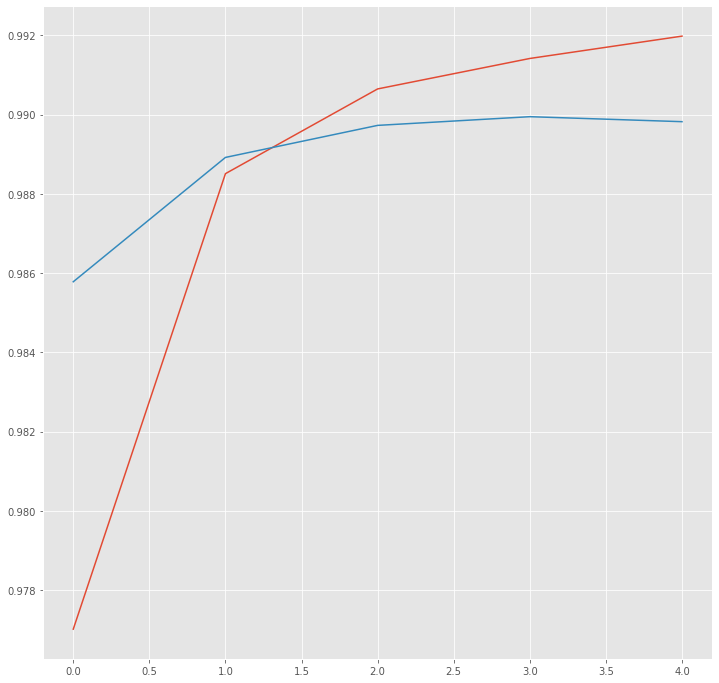

In [121]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["crf_viterbi_accuracy"])
plt.plot(hist["val_crf_viterbi_accuracy"])
plt.show()

### Evaluation 

In [124]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

In [126]:
test_pred = model.predict(tst_x, verbose=1)

4796/4796 [==============================] - 3s 687us/step


In [149]:
test_pred[:10]

array([[[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [127]:
idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out

In [128]:
pred_labels = pred2label(test_pred)
test_labels = pred2label(tst_y)

In [129]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 82.7%


In [130]:
print(classification_report(test_labels, pred_labels))

           precision    recall  f1-score   support

      per       0.73      0.78      0.75      1723
      gpe       0.97      0.93      0.95      1614
      tim       0.91      0.82      0.86      2005
      geo       0.85      0.88      0.86      3799
      org       0.76      0.64      0.69      2002
      art       0.00      0.00      0.00        40
      eve       0.50      0.04      0.07        26
      nat       0.00      0.00      0.00        16

micro avg       0.84      0.81      0.83     11225
macro avg       0.84      0.81      0.82     11225



In [152]:
i = 1928
p = model.predict(np.array([tst_x[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(tst_y[i], -1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(tst_x[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-1], tags[t], tags[pred]))

Word           ||True ||Pred
Rwanda         : B-org B-org
has            : O     O
threatened     : O     O
to             : O     O
go             : O     O
after          : O     O
the            : O     O
rebels         : O     O
if             : O     O
they           : O     O
are            : O     O
not            : O     O
disarmed       : O     O
.              : O     O
Shadid         : O     O
Shadid         : O     O
Shadid         : O     O
Shadid         : O     O
Shadid         : O     O
Shadid         : O     O
Shadid         : O     O
Shadid         : O     O
Shadid         : O     O
Shadid         : O     O
Shadid         : O     O
Shadid         : O     O
Shadid         : O     O
Shadid         : O     O
Shadid         : O     O
Shadid         : O     O
Shadid         : O     O
Shadid         : O     O
Shadid         : O     O
Shadid         : O     O
Shadid         : O     O
Shadid         : O     O
Shadid         : O     O
Shadid         : O     O
Shadid         : 

### Infrenece with the LSTM-CRF

In [133]:
test_sentence = ["Hawking", "was", "a", "Fellow", "of", "the", "Royal", "Society", ",", "a", "lifetime", "member",
                 "of", "the", "Pontifical", "Academy", "of", "Sciences", ",", "and", "a", "recipient", "of",
                 "the", "Presidential", "Medal", "of", "Freedom", ",", "the", "highest", "civilian", "award",
                 "in", "the", "United", "States", "."]

In [142]:
x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in test_sentence]],
                            padding="post", value=0, maxlen=max_len)
x_test_sent

array([[    0,  8640, 19649, 29993, 12664, 29777, 23605,   510, 14472,
        19649, 18436, 24844, 12664, 29777, 34528, 23312, 12664, 12219,
        14472,  1006, 19649, 21737, 12664, 29777, 24026,     0, 12664,
        17956, 14472, 29777, 11738, 11598, 18576, 30588, 29777,  3978,
         7749, 31021,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0]], dtype=int32)

In [145]:
x_test_sent.shape

(1, 75)

In [153]:
# predict with the model
p = model.predict(np.array([x_test_sent[0]]))
p = np.argmax(p, axis=-1)

print('{:15}||{}'.format("Word", "Prediction"))
print('=' * 30)

for w, pred in zip(test_sentence, p[0]):
    print('{:15}: {:5}'.format(w, tags[pred]))

Word           ||Prediction
Hawking        : O    
was            : O    
a              : O    
Fellow         : O    
of             : O    
the            : O    
Royal          : B-org
Society        : I-org
,              : O    
a              : O    
lifetime       : O    
member         : O    
of             : O    
the            : O    
Pontifical     : B-org
Academy        : I-org
of             : I-org
Sciences       : I-org
,              : O    
and            : O    
a              : O    
recipient      : O    
of             : O    
the            : O    
Presidential   : B-org
Medal          : I-org
of             : I-org
Freedom        : I-org
,              : O    
the            : O    
highest        : O    
civilian       : O    
award          : O    
in             : O    
the            : O    
United         : B-geo
States         : I-geo
.              : O    
